In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle

In [3]:
with open('C:/Users/hp/OneDrive/Documents/AML Capstone Project/Player-Performance-Improvement-Prediction/Data Gathering/Datasets/df_2018_to_2021_with_draftkings_score.pkl','rb') as f:
    df = pickle.load(f)

In [4]:
df = pd.DataFrame(df)

In [5]:
df['Game Date'] = pd.to_datetime(df['Game Date'])

In [6]:
df.drop(["Player Name",
         "Season ID",
         "Player ID",
         "Game ID",
         "Matchup",
         "Game Date",
         "Player Team",
         "Opponent", 
         "Home",
         "Won",
         "Player Efficiency Ratings"], axis=1, inplace=True)

df.head(2)

,Minutes played,Field Goals Made,Field Goals Attempted,Field Goals 3 Points Made,Field Goal 3 Points Attempt,Free Throws Made,Free Throws Attempt,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Double-double,Triple-double,DraftKings score
0,12,1,5,0,0,2,4,2,0,0,0,1,0,1,4,0,0,8.50
1,37,3,11,0,0,2,4,8,5,1,0,0,0,1,8,0,0,24.25


In [7]:
X = df.iloc[:-1, 0:-1].values
y = df.iloc[1:, -1].values

In [8]:
df.shape

(58153, 18)

In [9]:
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (58152, 17)
y.shape: (58152,)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

In [11]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (46521, 17)
X_test.shape: (11631, 17)
y_train.shape: (46521,)
y_test.shape: (11631,)


In [12]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(0,1))
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [13]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (46521, 17)
X_test.shape: (11631, 17)
y_train.shape: (46521,)
y_test.shape: (11631,)


In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90)
x_train_pca = pca.fit_transform(X_train)


In [21]:
x_test_pca = pca.transform(X_test)

In [22]:
x_train_pca = np.reshape(x_train_pca, (x_train_pca.shape[0], x_train_pca.shape[1], 1))
print(f'X_train.shape: {x_train_pca.shape}')

X_train.shape: (46521, 9, 1)


In [24]:
len(x_train_pca[0])

9

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

#Adding the first LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train_pca.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a thrid LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

#adding the output layer
regressor.add(Dense(units = 1))

#Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(x_train_pca, y_train, epochs = 10, batch_size = 6, verbose=1)

Epoch 1/10
7754/7754 [==============================] - 117s 14ms/step - loss: 468.9115
Epoch 2/10
7754/7754 [==============================] - 113s 15ms/step - loss: 400.5865
Epoch 3/10
7754/7754 [==============================] - 114s 15ms/step - loss: 395.1089
Epoch 4/10
7754/7754 [==============================] - 114s 15ms/step - loss: 393.6154
Epoch 5/10
7754/7754 [==============================] - 105s 14ms/step - loss: 390.3712
Epoch 6/10
7754/7754 [==============================] - 95s 12ms/step - loss: 388.2994
Epoch 7/10
7754/7754 [==============================] - 99s 13ms/step - loss: 387.5994
Epoch 8/10
7754/7754 [==============================] - 93s 12ms/step - loss: 386.0748
Epoch 9/10
7754/7754 [==============================] - 110s 14ms/step - loss: 384.9137
Epoch 10/10
7754/7754 [==============================] - 103s 13ms/step - loss: 383.0913


In [26]:
y_pred = regressor.predict(x_test_pca)

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

395.5456036309514

In [28]:
y_pred.shape

(11631, 1)

In [29]:
y_test.shape

(11631,)

In [30]:
y_pred.reshape(-1).shape

(11631,)

In [31]:
np.concatenate((y_test, y_pred.reshape(-1)), axis=0).shape

(23262,)

In [32]:
scatter_df = pd.DataFrame(np.concatenate((y_test, y_pred.reshape(-1)), axis=0), columns=['Value'])

real_predicted = ['Real Value'] * int(scatter_df.shape[0]/2) + ['Predicted Value'] * int(scatter_df.shape[0]/2)
scatter_df['Real/Predicted'] = real_predicted
scatter_df['Sample'] = list(range(int(scatter_df.shape[0]/2))) * 2
scatter_df.head(2)

,Value,Real/Predicted,Sample
0,10.50,Real Value,0
1,25.75,Real Value,1


<AxesSubplot:xlabel='Sample', ylabel='Value'>

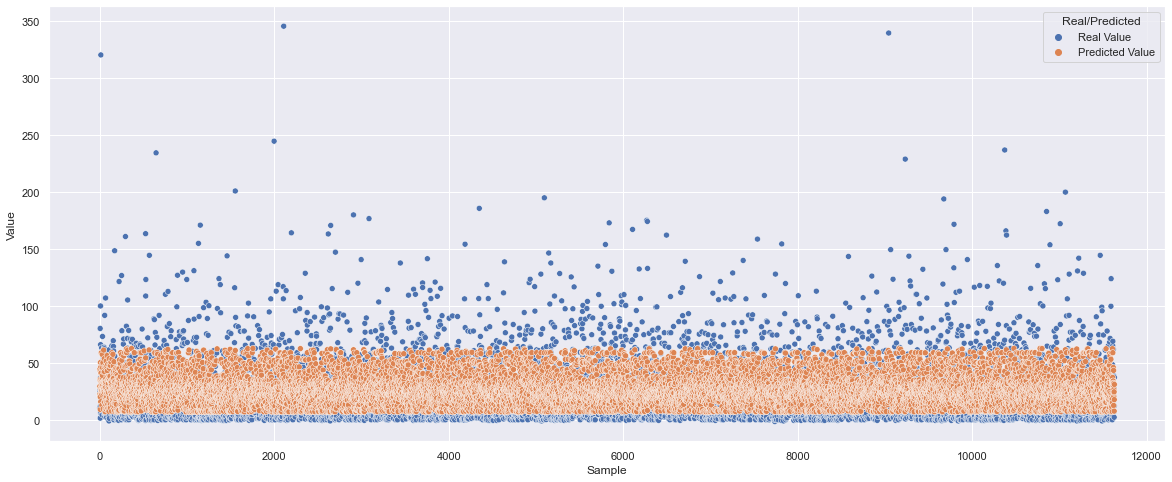

In [33]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 8)})
sns.scatterplot(data=scatter_df, x='Sample', y='Value', hue='Real/Predicted')

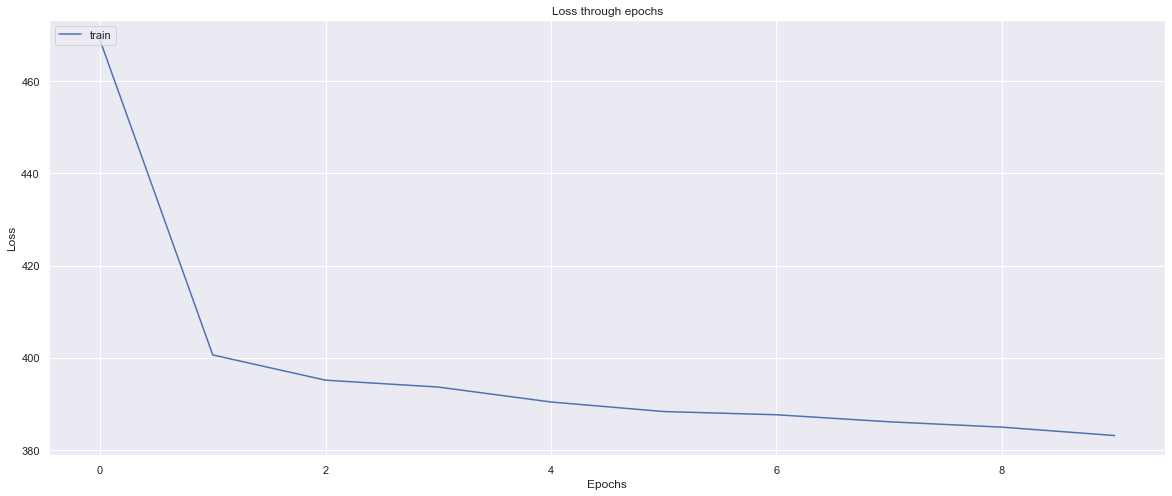

In [34]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.title('Loss through epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()